In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

In [2]:
import os
openai_api_key = os.getenv("OPENAI_API_KEY")
load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI
openai_model = ChatOpenAI(model = "gpt-4", openai_api_key = openai_api_key)
openai_model.invoke("Hello there").content

'Hello! How can I assist you today?'

In [35]:
from langchain_groq import ChatGroq
groq_model = ChatGroq(model="deepseek-r1-distill-llama-70b")
groq_model.invoke("Hello there").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [23]:
@tool
def transfer_to_multiplication_expert():
    """Ask mutltiplication agent for help"""
    return

In [24]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [25]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = openai_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [26]:
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = openai_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}


In [27]:
graph = StateGraph(MessagesState)

graph.add_node("additional_expert", additional_expert)
graph.add_node("multiplication_expert", multiplication_expert)


In [28]:
graph.add_edge(START, "additional_expert")

In [29]:
app = graph.compile()

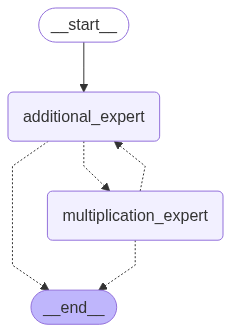

In [30]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
app.invoke({"messages": [("user", "What is (3 + 5) * 12. Please providem me the ouput.")]})

{'messages': [HumanMessage(content='What is (3 + 5) * 12. Please providem me the ouput.', additional_kwargs={}, response_metadata={}, id='53645123-2828-4be7-a838-0206ab0be73c'),
  AIMessage(content='The value of (3 + 5) is 8. Now, to find out the value of 8 * 12, I shall transfer this task to the multiplication expert.', additional_kwargs={'tool_calls': [{'id': 'call_fef4v0smCeOMc5EiTVwZFEHY', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 93, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-Br6POVYY3ZLC0lnanS5wj0OEdOleg', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': Non

In [32]:
from langchain_core.messages import convert_to_messages
def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [33]:
# Let's run the graph with an expression that requires both addition and multiplication:
for chunk in app.stream(
    {"messages": [("user", "what's (3 + 5) * 12. Provide me the output")]},
):
    print("****chunk...****")
    
    pretty_print_messages(chunk)

****chunk...****
Update from node additional_expert:


================================== Ai Message ==================================

The addition part of the calculation is 3 + 5 = 8.

To complete the operation, I'll have to ask the multiplication expert to calculate 8 * 12. 

Passing it to the multiplication expert now.
Tool Calls:
  transfer_to_multiplication_expert (call_zkptBEekQ7vEpdx5FXSrquZm)
 Call ID: call_zkptBEekQ7vEpdx5FXSrquZm
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk...****
Update from node multiplication_expert:


================================== Ai Message ==================================

The result of 8 * 12 is 96. So the final output of the operation (3 + 5) * 12 is 96.




In [34]:
@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    return
@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return

In [36]:
def travel_advisor(state: MessagesState) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = groq_model.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})
    
    return {"messages": [ai_msg]}

In [ ]:
def hotel_advisor(state: MessagesState) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = groq_model.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [38]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("travel_advisor", travel_advisor)
graph_builder.add_node("hotel_advisor", hotel_advisor)

In [39]:
# we'll always start with a general travel advisor
graph_builder.add_edge(START, "travel_advisor")

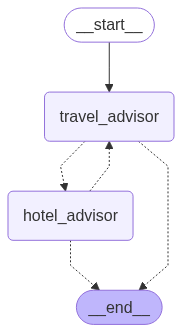

In [40]:
app = graph_builder.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [41]:
app.invoke({"messages":[("user","I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]})

{'messages': [HumanMessage(content='I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?', additional_kwargs={}, response_metadata={}, id='93fb3e99-50e7-4974-95d4-b2109bccab7e'),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Alright, the user is planning a trip from Mumbai to California in the USA. They’re asking for travel options and hotel recommendations. First, I need to figure out the best way to assist them. Since they mentioned both travel options and hotels, I should address each part.\n\nFor the travel options, I can suggest flying from Mumbai to major Californian cities like Los Angeles (LAX) or San Francisco (SFO) as these have direct flights. Airlines like Air India, United, or Delta might be good options. I can also mention the typical flight duration to set their expectations.\n\nBut the user also asked for hotel recommendations. I remember that I have a tool called hotel_advisor t

In [44]:
for chunk in app.stream(
    {"messages": [("user", "I am planning a trip to the Cape town in the south africa from Nairobi. Can you guide me on travel options and suggest the best hotel?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (jacsbz2s3)
 Call ID: jacsbz2s3
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_travel_advisor (j4msdn7my)
 Call ID: j4msdn7my
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================

Got it! I'll help you with your travel plans to Cape Town, South Africa. First, let me assist you with travel options and then transfer you to the hotel advisor for the best accommodation recommendations.




In [45]:
for chunk in app.stream(
    {"messages": [("user", "What are the best flight options from Nairobi to South Africa, and can you recommend top hotels for a comfortable and convenient stay?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (bv37ffh0q)
 Call ID: bv37ffh0q
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================

To address your query about the best flight options from Nairobi to South Africa and recommendations for top hotels, here's a structured approach:

### Flight Options from Nairobi to South Africa

1. **Direct Flights:**
   - **Kenya Airways:** Offers direct flights from Nairobi (JKIA) to Johannesburg (OR Tambo International Airport).
   - **South African Airways:** Although they may not operate direct flights from Nairobi, they have good connectivity within South Africa.

2. **Connecting Flights:**
   - **Ethiopian Airlines:** Flights with layov